# <font color='black'>Quora Question Pairs</font>
he goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the datase

### Data fields
- **id** - the id of a training set question pair
- **qid1, qid2** - unique ids of each question (only available in train.csv)
- **question1, question2** - the full text of each question
- **is_duplicate** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [82]:
## Required Libraries to this Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
exclude = string.punctuation
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sloke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
inp = pd.read_csv('train.csv')
inp.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
inp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
inp.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
inp = inp.sample(n=30000, random_state=2)
## reduce system complex i took only 30,000 samples values from given data

In [6]:
inp.duplicated().sum()

0

<Axes: xlabel='is_duplicate'>

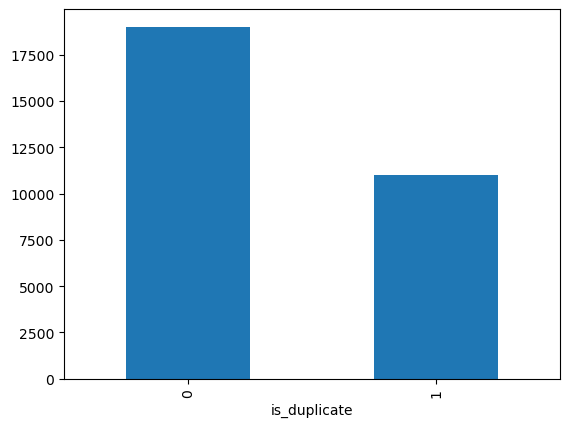

In [7]:
inp['is_duplicate'].value_counts().plot(kind='bar')

- By Viewing The barplot **75%** are No_duplicate remaining **25%** is Duplicate 

## Data Preprocessing

In [8]:
def preprocess(text):
    text = str(text).lower()
    
    ## replace certain char
    text = text.replace("%", 'percent')
    text = text.replace("$", 'dollar')
    text = text.replace('₹', 'rupee')
    text = text.replace('€', 'euro')
    text = text.replace('@', 'at')
    
    ## the pattern 'math' appears 900 times in the whole dataset
    text = text.replace('[math]', '')
    
    text = text.replace(',000,000,000 ', 'b ')
    text = text.replace(',000,000 ', 'm ')
    text = text.replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    
    
    q_concat = []
    for i in text.split():
        if i in contractions:
            i = contractions[i]
        q_concat.append(i)
        
    text = ' '.join(q_concat)
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")
    
    ## remove html tags 
    text = BeautifulSoup(text)
    text = text.get_text()
    
    ## remove the Punctuation and apply Lemmatization Technique to reduce base form words 
    exclude = string.punctuation
    punc = ''.join([i for i in text if i not in exclude])
    wordnet = ' '.join([lemma.lemmatize(i) for i in punc.split()])
    return wordnet

In [9]:
inp['question1'] = inp['question1'].apply(preprocess)
inp['question2'] = inp['question2'].apply(preprocess)

In [10]:
## find the len of question 1 and 2 
inp['len_q1'] = inp['question1'].str.len()
inp['len_q2'] = inp['question2'].str.len()

In [11]:
## find the total number of words in question1 and 2
inp['num_words_q1'] = inp['question1'].apply(lambda x: len(x.split(' ')))
inp['num_words_q2'] = inp['question2'].apply(lambda x: len(x.split(' ')))

In [12]:
def common_words(text):
    w1 = set(map(lambda x: x.lower().strip(), text['question1'].split(' ')))
    w2 = set(map(lambda x: x.lower().strip(), text['question2'].split(' ')))
    return len(w1 & w2)

In [13]:
inp['common_words'] = inp.apply(common_words, axis=1)
inp.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,72,73,12,12,11


In [14]:
def total_words(text):
    w1 = set(map(lambda x: x.lower().strip(), text['question1'].split()))
    w2 = set(map(lambda x: x.lower().strip(), text['question2'].split()))
    return len(w1)+len(w2)
inp['total_words'] = inp.apply(total_words, axis=1)

In [15]:
inp['word_share'] = round(inp['common_words']/ inp['total_words'], 2)
inp.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words,total_words,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,72,73,12,12,11,24,0.46


In [16]:
## advanced feature
def fetch_token(text):
    
    q1 = text['question1']
    q2 = text['question2']
    
    stop = stopwords.words('english')
    safe_div = 0.0001
    token_feature = [0.0]*8
    
    ## convert words into tokens:
    q1_token = q1.split()
    q2_token = q2.split()
    
    if len(q1_token)==0 or len(q2_token)==0:
        return token_feature
    
    ## fetch the words after applying the stopwords from given question 1 and 2
    q1_words = set([i for i in q1_token if i not in stop])
    q2_words = set([i for i in q2_token if i not in stop])
    
    ## fetch the removed stopwords like 'the', 'and', 'i' so and so from given question 1 and 2
    q1_stop = set([i for i in q1_token if i in stop])
    q2_stop = set([i for i in q2_token if i in stop])
    
    ## find the len of common_words  
    common_word_count = len(q1_words.intersection(q2_words))
    
    ## find the len of common_stop_words
    common_stop_count = len(q1_stop.intersection(q2_stop))
    
    ## find the len of common_splitted words
    common_token_count = len(set(q1_token). intersection(set(q2_token)))
    
    ## cwc_min: This is the ratio of the number of common words to the length of the smaller question
    token_feature[0] = common_word_count / (min(len(q1_words), len(q2_words)) + safe_div)
    
    ## cwc_max: This is the ratio of the number of common words to the length of the larger question
    token_feature[1] = common_word_count / (max(len(q1_words), len(q2_words)) + safe_div)
    
    ## csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
    token_feature[2] = common_stop_count / (min(len(q1_stop), len(q2_stop)) + safe_div)
    
    ## csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
    token_feature[3] = common_stop_count / (max(len(q1_stop), len(q2_stop)) + safe_div)
    ## ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
    token_feature[4] = common_token_count / (min(len(q1_token), len(q2_token)) + safe_div)
    ## ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
    token_feature[5] = common_token_count / (max(len(q1_token), len(q2_token)) + safe_div)
    
    ## last_word_eq: 1 if the last word in the given two questions is same, 0 otherwise
    ## first_word_eq: 1 if the first word in the two questions is same, 0 otherwise
    token_feature[6] = int(q1_token[-1] == q2_token[-1])
    token_feature[7] = int(q1_token[0] == q2_token[0])
    
    return token_feature

In [17]:
token_feature = inp.apply(fetch_token, axis=1)
#token_feature[0]

In [18]:
inp['cwc_min'] = list(map(lambda x: x[0], token_feature))
inp['cwc_max'] = list(map(lambda x: x[1], token_feature))
inp['csc_min'] = list(map(lambda x: x[2], token_feature))
inp['csc_max'] = list(map(lambda x: x[3], token_feature))
inp['ctc_min'] = list(map(lambda x: x[4], token_feature))
inp['ctc_max'] = list(map(lambda x: x[5], token_feature))
inp['last_word_equ'] = list(map(lambda x: x[6], token_feature))
inp['first_word_equ'] = list(map(lambda x: x[7], token_feature))

## 2. Length Based Features
- mean_len: Mean of the length of the two questions (number of words)
- abs_len_diff: Absolute difference between the length of the two questions (number of words)
- longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

In [19]:
!pip install distance

In [20]:
import distance

def length_base(text):
    q1 = text['question1']
    q2 = text['question2']
    
    ## tokenize the text q1 and q2
    token_q1 = q1.split()
    token_q2 = q2.split()
    
    length_feature = [0.0]*3
    
    if len(token_q1)==0 or len(token_q2)==0:
        return length_feature
    
    length_feature[0] = abs(len(token_q1) - len(token_q2))
    length_feature[1] = (len(token_q1) + len(token_q2))/2
    
    ## find the distance of sub_string in given q1 and q1
    strs = list(distance.lcsubstrings(q1, q2))
    
    ## find the ratio of given length sub_string for given length small question 
    length_feature[2] = len(strs)/(min(len(q1),len(q2)) + 1)
    return length_feature

In [21]:
length_features = inp.apply(length_base, axis=1)
inp['abs_len_diff'] = list(map(lambda x: x[0], length_features))
inp['min_len'] = list(map(lambda x: x[1], length_features))
inp['long_substr_ratio'] = list(map(lambda x: x[2], length_features))

## Fuzzy Features (Which matches given string and return the score)  
- fuzz_ratio: fuzz_ratio score from fuzzywuzzy
- fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
- token_sort_ratio: token_sort_ratio from fuzzywuzzy
- token_set_ratio: token_set_ratio from fuzzywuzzy

In [22]:
!pip install fuzzywuzzy

In [23]:
from fuzzywuzzy import fuzz

def fuzzy_ratio(text):
    q1 = text['question1']
    q2 = text['question2']
    
    fuzzy_feature = [0.0]*4
    
    ## fuzzy ratio
    fuzzy_feature[0] = fuzz.QRatio(q1, q2)
    ## fuzz_partial_ratio
    fuzzy_feature[1] = fuzz.partial_ratio(q1, q2)
    ## token_sort_ratio
    fuzzy_feature[2] = fuzz.token_sort_ratio(q1, q2)
    ## token_set_ratio
    fuzzy_feature[3] = fuzz.token_set_ratio(q1, q2)
    
    return fuzzy_feature

In [24]:
fuzzy = inp.apply(fuzzy_ratio, axis=1)
fuzzy

398782    [99, 99, 99, 99]
115086    [69, 66, 65, 74]
327711    [27, 30, 31, 39]
367788    [26, 46, 26, 31]
151235    [57, 71, 49, 71]
                ...       
243932    [89, 87, 78, 89]
91980     [60, 62, 49, 54]
266955    [32, 38, 56, 67]
71112     [72, 65, 72, 84]
312470    [35, 43, 62, 62]
Length: 30000, dtype: object

In [25]:
inp['fuz_ratio'] = list(map(lambda x: x[0], fuzzy))
inp['fuz_partial_ratio'] = list(map(lambda x: x[1], fuzzy))
inp['fuz_sort_ratio'] = list(map(lambda x: x[2], fuzzy))
inp['fuz_set_ratio'] = list(map(lambda x: x[3], fuzzy))

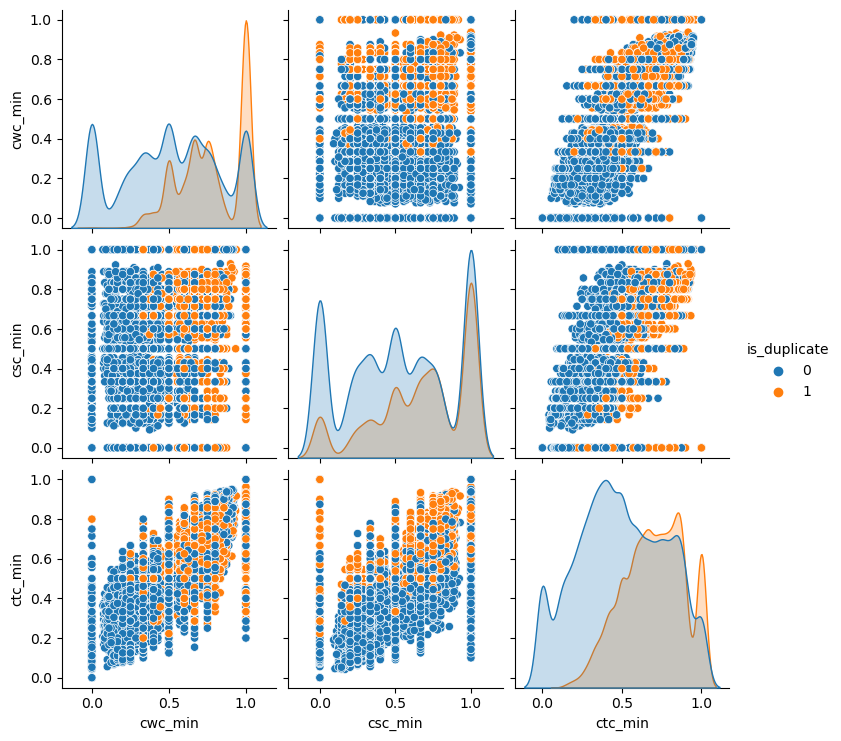

In [26]:
sns.pairplot(inp[['cwc_min','csc_min','ctc_min', 'is_duplicate']], hue='is_duplicate')
plt.show()

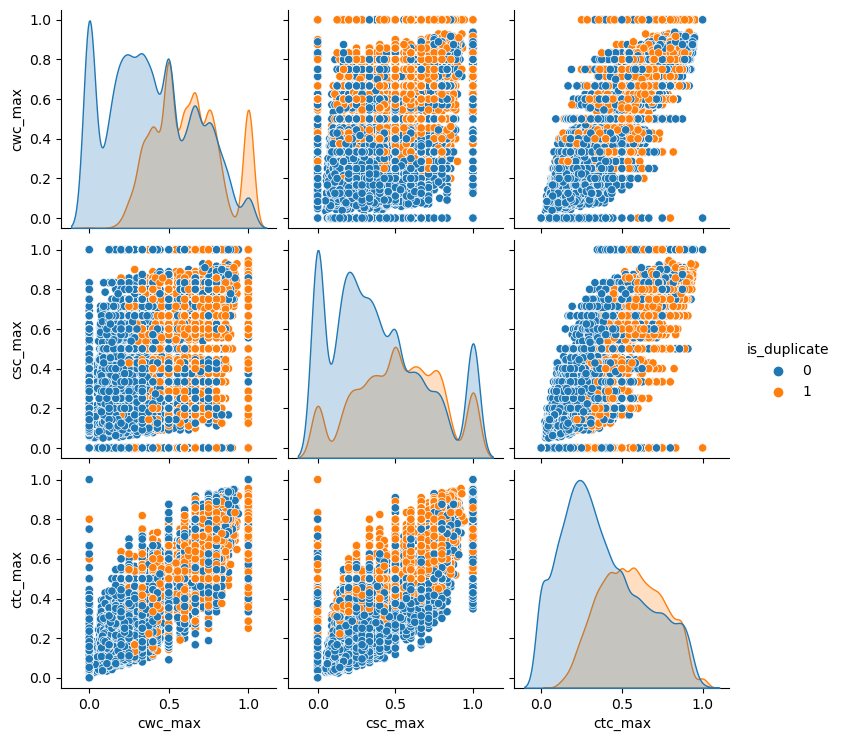

In [27]:
sns.pairplot(inp[['cwc_max','csc_max','ctc_max', 'is_duplicate']], hue='is_duplicate')
plt.show()

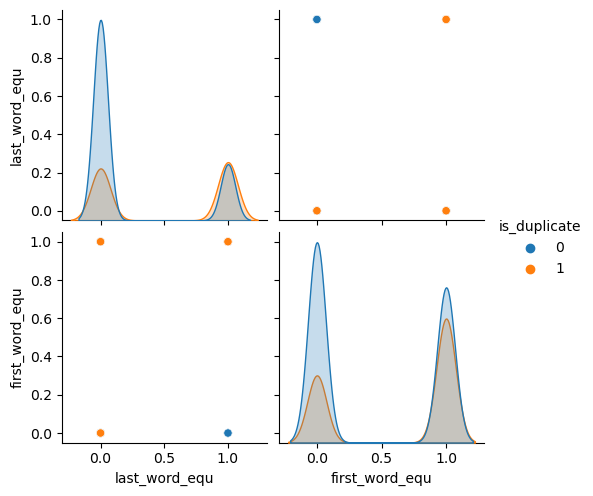

In [28]:
sns.pairplot(inp[['last_word_equ','first_word_equ', 'is_duplicate']], hue='is_duplicate')
plt.show()

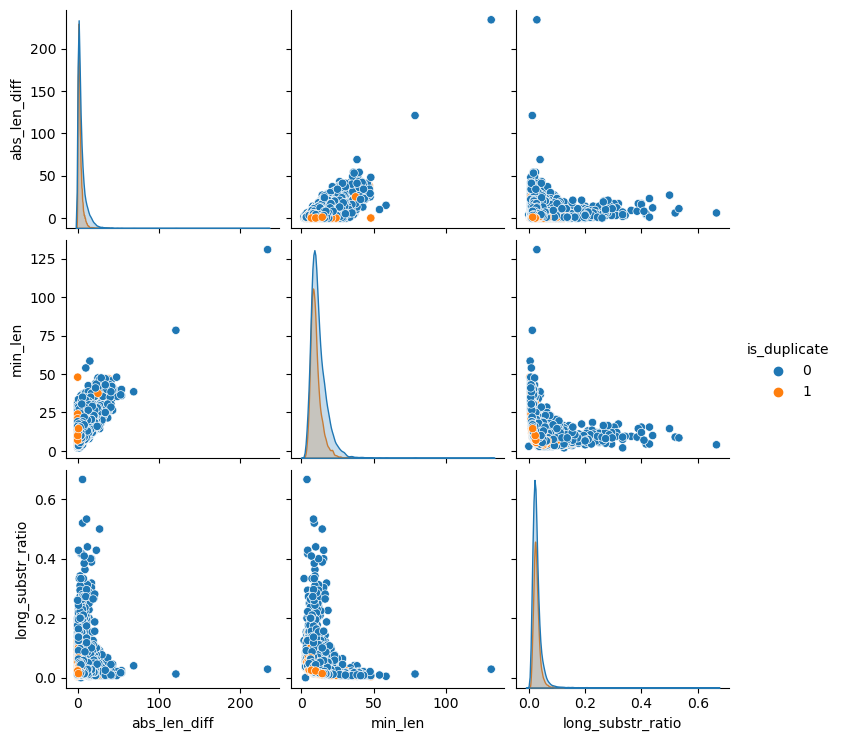

In [29]:
sns.pairplot(inp[['abs_len_diff','min_len','long_substr_ratio','is_duplicate']], hue='is_duplicate')
plt.show()

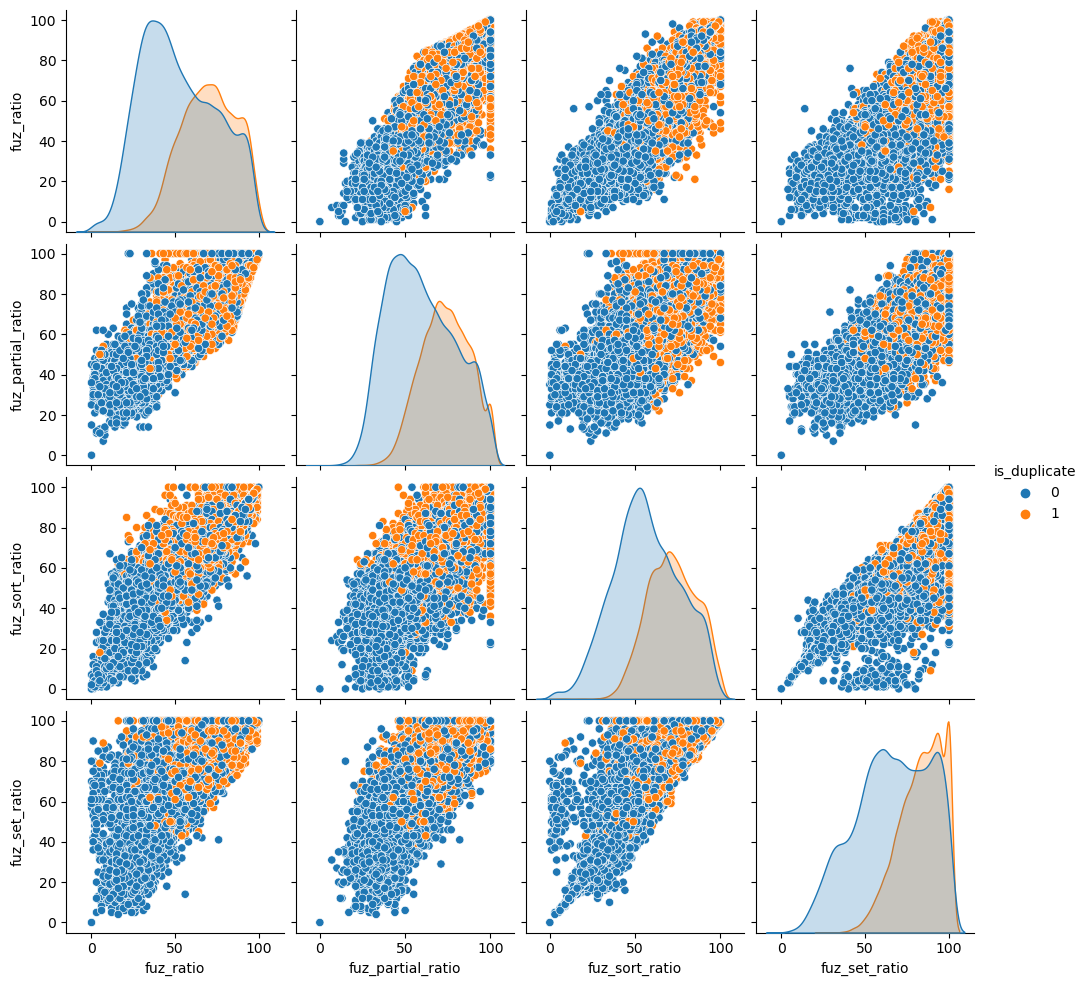

In [30]:
sns.pairplot(inp[['fuz_ratio','fuz_partial_ratio','fuz_sort_ratio','fuz_set_ratio', 'is_duplicate']],
             hue='is_duplicate')
plt.show()

In [31]:
## apply scaling for 15 create feature
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(inp[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max',
                              'last_word_equ','first_word_equ','abs_len_diff','min_len','long_substr_ratio',
                              'fuz_ratio','fuz_partial_ratio','fuz_sort_ratio','fuz_set_ratio']])
y = inp['is_duplicate']

In [32]:
## TNSE = to Visualize the High dim data  into low_dimension_embedding
from sklearn.manifold import TSNE
visual_2d = TSNE(n_components=2,
                 n_iter=1000,
                 init='pca',
                 verbose=2,
                 random_state=101,
                 method='barnes_hut',
                 angle=0.5,
                 n_jobs=1)
visual_2d.fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 1.798s...
[t-SNE] Computed neighbors for 30000 samples in 49.970s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

array([[-91.44118 , -13.623173],
       [-37.81238 ,  28.52782 ],
       [ 60.303436, -54.42309 ],
       ...,
       [ 41.707127,  20.87576 ],
       [-51.568943,  62.61579 ],
       [ 66.46612 ,  20.695272]], dtype=float32)

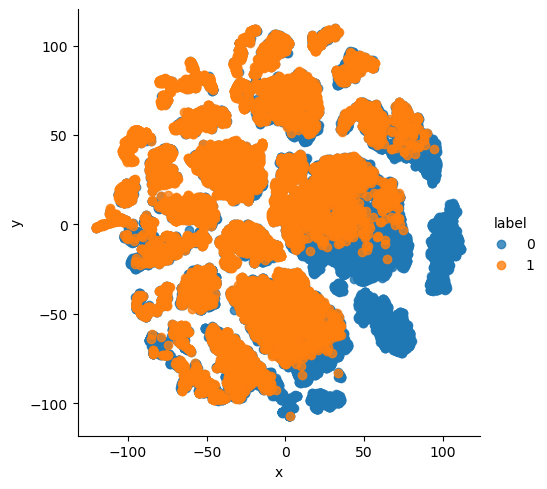

In [33]:
## to visalize the TSNE importing value inside dataframe

x_df = pd.DataFrame({'x':visual_2d.embedding_[:,0], 'y':visual_2d.embedding_[:,1], 'label':y})
sns.lmplot(data=x_df, x='x', y='y', hue='label',  fit_reg=False, markers='o')

- By Seeing the Visuals we can understand that no_duplicate value are about 60% and duplicate value are about 40% 

### Feature Engineering

In [34]:
quest = inp[['question1', 'question2']]
df = inp.drop(['id','qid1','qid2', 'question1','question2'], axis=1)
df.head(2)

,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words,total_words,word_share,cwc_min,cwc_max,...,ctc_max,last_word_equ,first_word_equ,abs_len_diff,min_len,long_substr_ratio,fuz_ratio,fuz_partial_ratio,fuz_sort_ratio,fuz_set_ratio
398782,1,72,73,12,12,11,24,0.46,0.857131,0.857131,...,0.916659,1,1,0,12.0,0.013699,99,99,99,99
115086,0,47,55,12,15,7,22,0.32,0.666644,0.499988,...,0.466664,1,1,3,13.5,0.020833,69,66,65,74


In [35]:
df.shape

(30000, 23)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=2000)

## combine the two columns to extract the bagofwords vectors values
combine_question = list(quest['question1']) + list(quest['question2'])

## applying np.vsplit() to separate the given two columns of questions
q1_array, q2_array = np.vsplit(tf.fit_transform(combine_question).toarray(), 2)

## vectorized value into Dataframe to further concat to main_dataframe
q1_df = pd.DataFrame(q1_array, index=quest.index)
q2_df = pd.DataFrame(q2_array, index=quest.index)
q1_q2_concat = pd.concat([q1_df, q2_df], axis=1)
new_df = pd.concat([df,q1_q2_concat], axis=1)
new_df.head(3)

,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words,total_words,word_share,cwc_min,cwc_max,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
398782,1,72,73,12,12,11,24,0.46,0.857131,0.857131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115086,0,47,55,12,15,7,22,0.32,0.666644,0.499988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327711,0,101,115,25,17,2,34,0.06,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Creation Training and Testing

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(new_df.iloc[:,1:].values, 
                                                    new_df.iloc[:,0].values, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)

0.7843333333333333

### Test Case verify

In [39]:
## token check
def test_token(q1, q2):
    exclude = stopwords.words('english')
    balance_div = 0.0001
    
    token_feature = [0.0]*8
    
    ## convert sentence into token
    token_q1 = q1.split()
    token_q2 = q2.split()
    
    ## checking that token1 and 2 which len is equal to 0 sending to token_feature
    if (len(token_q1)==0) or (len(token_q2)==0):
        return token_feature
    
    ## calculate the len of common_word in given question
    q1_word = set([i for i in q1.lower().split() if i not in exclude])
    q2_word = set([i for i in q2.lower().split() if i not in exclude])
    common_word = len(q1_word.intersection(q2_word))
    
    ## calculate the len of common_stopwords from given question
    q1_stop = set([i for i in q1.lower().split() if i in exclude])
    q2_stop = set([i for i in q2.lower().split() if i in exclude])
    common_stopword = len(q1_stop.intersection(q2_stop))
    
    ## calculate the len of token_words from given question
    common_token = len(set(token_q1).intersection(set(token_q2)))
    
    token_feature[0] = common_word / (min(len(q1_word), len(q2_word)) + balance_div)
    token_feature[1] = common_word / (max(len(q1_word), len(q2_word)) + balance_div)
    token_feature[2] = common_stopword / (min(len(q1_stop), len(q2_stop)) + balance_div)
    token_feature[3] = common_stopword / (max(len(q1_stop), len(q2_stop)) + balance_div)
    token_feature[4] = common_token / (min(len(token_q1), len(token_q2)) + balance_div)
    token_feature[5] = common_token / (max(len(token_q1), len(token_q2)) + balance_div)
    token_feature[6] = int(token_q1[-1] == token_q2==[-1])
    token_feature[7] = int(token_q1[0] == token_q2==[0])
    return token_feature

In [40]:
def test_length_based_feature(q1, q2):
    balance_div = 1
    length_feature = [0.0]*3
    
    token_q1 = q1.split()
    token_q2 = q2.split()
    
    if len(token_q1)==0 or len(token_q2)==0:
        return length_feature
    
    length_feature[0] = (len(token_q1) + len(token_q2))/2
    length_feature[1] = abs(len(token_q1) - len(token_q2))
    sub_string_2quest = (distance.lcsubstrings(q1, q2))
    length_feature[2] = len(sub_string_2quest) / (min(len(q1), len(q2)) + balance_div)
    return length_feature

In [41]:
def test_fuzz_code(q1, q2):
    fuzz_feature = [0.0]*4
    fuzz_feature[0] = fuzz.QRatio(q1, q2)
    fuzz_feature[1] = fuzz.partial_ratio(q1, q2)
    fuzz_feature[2] = fuzz.token_sort_ratio(q1, q2)
    fuzz_feature[3] = fuzz.token_set_ratio(q1, q2)
    return fuzz_feature

In [42]:
def test_case_verify(q1, q2):
    
    question_test = []
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    ## find the len of the word
    question_test.append(len(q1))
    question_test.append(len(q2))
    ## total number of word for each rows
    question_test.append(len(q1.strip(' ')))
    question_test.append(len(q2.strip(' ')))
    
    ## find the common_word 
    def test_common_word(q1, q2):
        w1 = set(map(lambda x: x.lower().strip(), q1.split(' ')))
        w2 = set(map(lambda x: x.lower().strip(), q1.split(' ')))
        return len(w1 & w2)
    question_test.append(test_common_word(q1, q2))
    
    
    ## find the total_word
    def test_total_word(q1, q2):
        w1 = set(map(lambda x: x.lower().strip(), q1.split(' ')))
        w2 = set(map(lambda x: x.lower().strip(), q2.split(' ')))
        return (len(w1)+len(w2))
    question_test.append(test_total_word(q1, q2))
    
    ## word share from common_word and total_word
    question_test.append(round(test_common_word(q1, q2)/ test_total_word(q1, q2)))
    
    ## extend to token_feature 
    test_token_feature = test_token(q1, q2)
    question_test.extend(test_token_feature)
    
    ## extend the length_feature
    test_length_feature = test_length_based_feature(q1, q2)
    question_test.extend(test_length_feature)
    
    ## extend the fuzz_feature
    test_fuzz_feature = test_fuzz_code(q1, q2)
    question_test.extend(test_fuzz_feature)
    
    ## apply the feature_extraction of TfIdfVectorizer in q1 and q2
    q1_tf = tf.transform([q1]).toarray()
    q2_tf = tf.transform([q2]).toarray()
    
    single_vect = np.hstack((np.array(question_test).reshape(1, 22),q1_tf,q2_tf))
    return single_vect

# <font color='red'>Predicting Unknown Text</font> 
   - <font color='black'>**Duplicate[1]= Similar meaning in given text**</font>
   - <font color='black'>**No_Duplicate[0] = no similar meaning in given text**</font>

In [43]:
q1 = 'Where is the capital of India?'
q2 = 'What is the business capital of India?'

In [72]:
pred = rf.predict(test_case_verify(q1, q1))
if pred==np.array(0):
    print('No Similar Meaning')
else:
    print("Similar Meaning")

Similar Meaning


- we can see the output as which shows Similar Meaning were we can take it has **Duplicate**

# <font color='purple'>Model Improvement Possible</font>
   - According Your System requirement 
       - Total Count of values we have 404290 in this Required 30000 sample of data to reduce speed of system
       - **Hyperparameter Tuning** is also possible 
       - Feature Extraction I used **TFIDFVectorizer**(Term Frequency Inverse Document Frequency) even we can use **Word2Vec**
       - Different type of Algorithm acceptable **SVM** Even We can use Deep Learning Technique in that we can use **Transformers** better result 